# Fitting Data with LRMoE

## Introduction

In this notebook, we will demonstrate how to fit data with LRMoE. We start by simulating data from a two-component mixture, and then artificially impose data truncation. We then fit the data with LRMoE and assess the model fit.

In [1]:
using DrWatson
@quickactivate "LRMoEjl Demo"

using CategoricalArrays, DataFrames, Distributions
using GLM, LRMoE, JLD2, PrettyTables, Random

# some helper functions are hidden in a separate source file
include(srcdir("2023-iCAS-new-util.jl"))
using .continuous_util_jl:
    plot_simulated_obs,
    plot_LRMoE_fit,
    plot_simulated_T_delay,
    plot_simulated_T_claim_T_delay,
    plot_observed_losses

## Data Simulation

Let us consider a synthetic dataset with continuous observations, e.g. loss severity, time of claims reporting delay, etc.  We first simulate some covariates typically considered in auto insurance.

In [2]:
Random.seed!(7777)
sample_size = 10_000

X = DataFrame(
    intercept = fill(1.0, sample_size),
    sex = rand(Binomial(1, 0.50), sample_size),
    aged = rand(Uniform(20, 80), sample_size),
    agec = rand(Uniform(0, 10), sample_size),
    region = rand(Binomial(1, 0.50), sample_size)
)

pretty_table(first(X, 5), nosubheader=true)

┌───────────┬─────┬─────────┬──────────┬────────┐
│ intercept │ sex │    aged │     agec │ region │
├───────────┼─────┼─────────┼──────────┼────────┤
│       1.0 │   0 │ 44.1331 │   7.8814 │      1 │
│       1.0 │   1 │ 35.9979 │  4.29332 │      1 │
│       1.0 │   0 │ 54.0499 │ 0.698563 │      1 │
│       1.0 │   0 │ 47.4046 │  4.78275 │      1 │
│       1.0 │   1 │ 32.7516 │  1.62825 │      1 │
└───────────┴─────┴─────────┴──────────┴────────┘


Our package currently supports:
- Discrete distribution (e.g. frequency modelling): Binomial, Negative Binomial, Poisson, Gamma Count
- Continuous distribution (e.g. severity modelling): Burr, Gamma, Inverse Gaussian, Lognormal, Weibull
- And the zero-inflated version of all of the above!

We assume the observations are generated from a two-component LRMoE model with the following parameters.

In [3]:
# logit regression coefficients
α = [-0.5 1.0 -0.05 0.1 1.25;
     0.0 0.0   0.0 0.0  0.0]
# expert functions
comp_dist = [LogNormalExpert(4.0, 0.3) InverseGaussianExpert(20, 20)];

Now we are ready to simulate the observations and visualize the distribution.

In [4]:
exact_obs = LRMoE.sim_dataset(α, X, comp_dist)
exact_obs = vec(exact_obs);

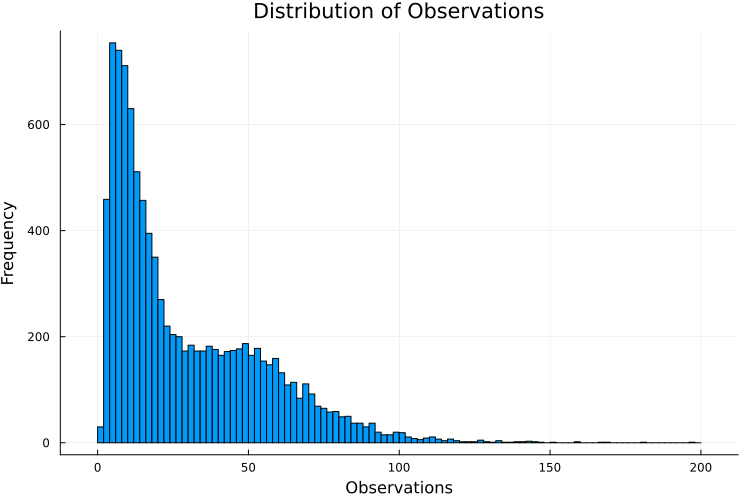

In [5]:
plot_simulated_obs(exact_obs)

## Fitting LRMoE to Exact Data

While the data are simulated from a mixture of Lognormal and Inverse Gaussian, we consider fitting a 2-component LRMoE mixture of Gamma distributions.  The goal is to assess the model fit when a 'wrong' distribution is used, which is almost always the case as we can never know the true distribution in reality.

To prepare for model fitting, the first step is to convert the original dataframe into matrix form (support for the `@formula` interface is a feature under development).

In [6]:
# convert observations to a matrix Y, which is needed for LRMoE
Y_mat = reshape(exact_obs, length(exact_obs), 1)
X_mat = Matrix(X);

The `LRMoE.jl` package provides a function for initializing a model, which provides initial values `α_init` for the logit regression parameters and `params_init` for all possible expert functions. We can pick out the Gamma initializations.

In [7]:
Random.seed!(7777)
n_comp = 2
model_init = cmm_init(Y_mat, X_mat, n_comp, ["continuous"]; exact_Y = true, n_random = 0)

model_init.params_init

# pickout desired parameter initializations
α_init = model_init.α_init
experts_init = vcat([hcat([model_init.params_init[1][j][2] for j in 1:n_comp]...) for d in 1:1]...)
# view
println("α_init: $(α_init)")
println("experts_init: $(experts_init[1, :])")

# dump(model_init, maxdepth = 0)

α_init: [-0.060818740035039176 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0]


experts_init: GammaExpert{Float64}[GammaExpert{Float64}(1.4474173017422336, 21.496379670674774), GammaExpert{Float64}(1.2633527342958775, 22.00745676388173)]


There are several settings to control the fitting function. For example, `ϵ` controls when to stop the ECM algorithm based on the increment in loglikelihood, while `ecm_iter_max` provides a hard stop after a certain number of iterations. More details can be found in the package [documentation](https://actsci.utstat.utoronto.ca/LRMoE.jl/stable/fit/).

In [8]:
LRMoE_model = fit_LRMoE(Y_mat, X_mat, α_init, experts_init;
    exact_Y=true, ϵ=0.01, ecm_iter_max=1000, print_steps=10)

┌ Info: Initial loglik: -43559.71265344292 (no penalty), -43557.57314779194 (with penalty)
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:50
┌ Info: Iteration 10, updating α: -43318.952456588195 ->  -43286.484061869014, ( + 0.07495193876564453 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:101
┌ Info: Iteration 10, updating model[1, 1]: -43286.484061869014 ->  -43273.19367271651, ( + 0.03070332331336919 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:133


┌ Info: Iteration 10, updating model[1, 2]: -43273.19367271651 ->  -43234.099950141856, ( + 0.09034166248584811 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:133


┌ Info: Iteration 20, updating α: -42565.508585382944 ->  -42560.233461587864, ( + 0.012392953756204365 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:101
┌ Info: Iteration 20, updating model[1, 1]: -42560.233461587864 ->  -42520.88681058969, ( + 0.09244933074365143 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:133
┌ Info: Iteration 20, updating model[1, 2]: -42520.88681058969 ->  -42496.770180946995, ( + 0.056717137039320124 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:133


┌ Info: Iteration 30, updating α: -42386.617690612475 ->  -42386.354507268785, ( + 0.0006209114056019076 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:101
┌ Info: Iteration 30, updating model[1, 1]: -42386.354507268785 ->  -42385.49731802357, ( + 0.0020223235878174747 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:133
┌ Info: Iteration 30, updating model[1, 2]: -42385.49731802357 ->  -42384.778428325924, ( + 0.0016960747027459117 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:133


┌ Info: Iteration 40, updating α: -42377.85370379924 ->  -42377.82048829121, ( + 7.83794013365082e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:101
┌ Info: Iteration 40, updating model[1, 1]: -42377.82048829121 ->  -42377.72613324562, ( + 0.0002226519545013118 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:133


┌ Info: Iteration 40, updating model[1, 2]: -42377.72613324562 ->  -42377.62099418063, ( + 0.00024809982644561306 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:133
┌ Info: Iteration 50, updating α: -42376.80559594202 ->  -42376.801972661306, ( + 8.550150647083791e-6 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:101
┌ Info: Iteration 50, updating model[1, 1]: -42376.801972661306 ->  -42376.79216208676, ( + 2.3150813871044885e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:133
┌ Info: Iteration 50, updating model[1, 2]: -42376.79216208676 ->  -42376.780254156256, ( + 2.8100122479562766e-5 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_exact.jl:133


LRMoESTDFit(LRMoESTD([0.26279441155737254 0.6058258489358791 … 0.06269424112470953 0.7750075633600627; 0.0 0.0 … 0.0 0.0], GammaExpert{Float64}[GammaExpert{Float64}(6.574219867979773, 8.187376085497817) GammaExpert{Float64}(2.7477071553457653, 4.562399794804151)]), true, 55, -42376.71246464911, -42380.49877196296, 84778.99754392591, 84843.8906072737)

In [9]:
summary(LRMoE_model)

Model: LRMoE
Fitting converged after 55 iterations
Dimension of response: 1
Number of components: 2
Loglik: -42376.71246464911
Loglik (no penalty): -42380.49877196296
AIC: 84778.99754392591
BIC: 84843.8906072737
Fitted α:
[0.26279441155737254 0.6058258489358791 -0.033489202420606205 0.06269424112470953 0.7750075633600627; 0.0 0.0 0.0 0.0 0.0]
Fitted component distributions:


GammaExpert{Float64}[GammaExpert{Float64}(6.574219867979773, 8.187376085497817) GammaExpert{Float64}(2.7477071553457653, 4.562399794804151)]


And we visualize the model fit.  We see that the LRMoE model can fit the data reasonably well even when it is not using the true experts.

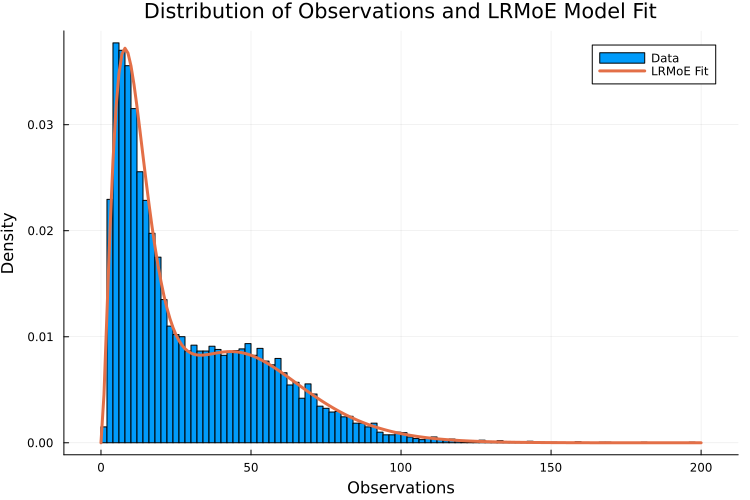

In [10]:
plot_LRMoE_fit(exact_obs, X_mat, LRMoE_model)

## Right-Truncated Reporting Delay

Claims reporting delays are essentially right-truncated data.  For all the observed claims, we know their reporting delays are less than a certain threshold - reporting delay must be less than the period between accident date and valuation date, otherwise the claim is unreported (incurred but not reported, IBNR).

Let us assume accidents occur uniformly within a year, i.e. `T_accident` follows a uniform distribution from 0 to 365.

In [11]:
Random.seed!(7777)
T_accident = rand(Uniform(0, 365), sample_size)
T_delay = exact_obs;

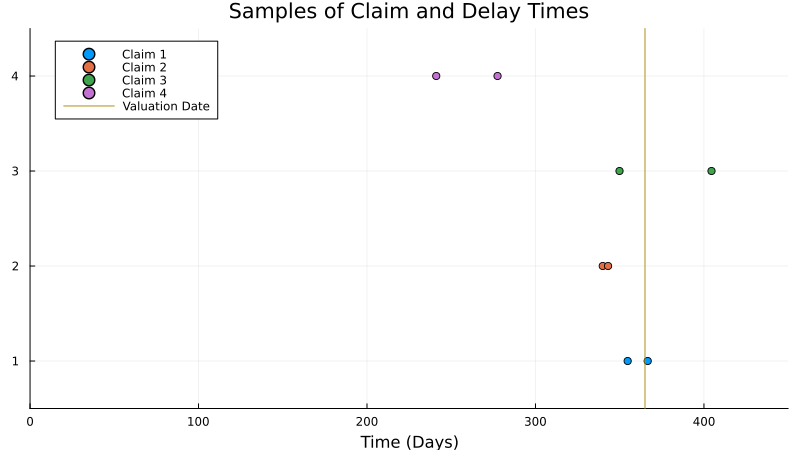

In [12]:
plot_idx  = vcat([findall(T_accident + T_delay .> 365)[1], findall(T_accident + T_delay .<= 365)[2],
                  findall(T_accident + T_delay .> 365)[3], findall(T_accident + T_delay .<= 365)[4],]...)

plot_simulated_T_claim_T_delay(T_accident, T_delay)

Let us also assume claims reserving is done at the end of year. With accident and reporting delay times simulated as above, we know `T_accident + T_delay` will be right-truncated at 365, which is roughly 8% of the data.

In [13]:
println("Number of truncated observations: $(sum((T_accident .+ T_delay) .> 365))")

Number of truncated observations: 829


Unlike the case of exact observations above, we require a special format for censored and/or truncated data.

Each observation of reporting delay will be accompanied by a right-truncation level `t_u = 365 - T_accident`.  Claims with reporting delay `T_delay` above this threshold will not be observed in reality.  The LRMoE model can also account for possible left-truncation with level `t_l` (see below), but in this example it will be set to zero.

In [14]:
# construct data frame for truncated observations
t_l = fill(0.0, sample_size)
t_u = 365 .- T_accident
truncation_idx = (T_accident .+ T_delay) .> 365

# view constructed data
df_view = DataFrame(
    T_accident = T_accident,
    T_delay = T_delay,
    T_report = T_accident .+ T_delay,
    truncation = truncation_idx,
    t_l = t_l,
    t_u = t_u
)

pretty_table(df_view[plot_idx,:], nosubheader=true)

┌────────────┬─────────┬──────────┬────────────┬─────┬─────────┐
│ T_accident │ T_delay │ T_report │ truncation │ t_l │     t_u │
├────────────┼─────────┼──────────┼────────────┼─────┼─────────┤
│    354.717 │ 11.8929 │   366.61 │       true │ 0.0 │ 10.2828 │
│    339.931 │ 3.15423 │  343.086 │      false │ 0.0 │ 25.0686 │
│    349.881 │ 54.6041 │  404.485 │       true │ 0.0 │  15.119 │
│    241.101 │ 36.3824 │  277.483 │      false │ 0.0 │ 123.899 │
└────────────┴─────────┴──────────┴────────────┴─────┴─────────┘


The LRMoE package also requires two additional bounds `(y_l, y_u)` to indicate potential data censoring. In this example of reporting delays, there is no censoring, so we set `y_l = y_u = T_delay` for all incurred and reported claims. All incurred but not reported claims will be dropped from the simulated dataset (as they are not reported they are not observed!).

In [15]:
y_l = T_delay
y_u = T_delay

# construct the complete dataframe
Y = DataFrame(t_l=t_l, y_l=y_l, y_u=y_u, t_u=t_u)
# drop truncated observations
Y_truncated = Y[.!truncation_idx, :]
X_truncated = X[.!truncation_idx, :]
pretty_table(first(Y, 5), nosubheader=true)

┌─────┬─────────┬─────────┬─────────┐
│ t_l │     y_l │     y_u │     t_u │
├─────┼─────────┼─────────┼─────────┤
│ 0.0 │ 50.5435 │ 50.5435 │ 84.1402 │
│ 0.0 │ 3.15423 │ 3.15423 │ 25.0686 │
│ 0.0 │ 22.0824 │ 22.0824 │ 29.7483 │
│ 0.0 │ 11.8929 │ 11.8929 │ 10.2828 │
│ 0.0 │ 36.3824 │ 36.3824 │ 123.899 │
└─────┴─────────┴─────────┴─────────┘


## Fitting LRMoE with Right-Truncated Data

We are now ready to fit the LRMoE to the truncated data, similar to the procedure above.

In [16]:
Random.seed!(7777)
n_comp = 2
model_init = cmm_init(Matrix(Y_truncated), Matrix(X_truncated), n_comp, ["continuous"]; exact_Y = false, n_random = 0)

model_init.params_init

# pickout desired parameter initializations
α_init = model_init.α_init
experts_init = vcat([hcat([model_init.params_init[1][j][2] for j in 1:n_comp]...) for d in 1:1]...)
# view
println("α_init: $(α_init)")
println("experts_init: $(experts_init[1, :])")

α_init: [-0.011122129698273753 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0]
experts_init: GammaExpert{Float64}[GammaExpert{Float64}(1.494618968665757, 20.870608292349), GammaExpert{Float64}(1.1855457454321903, 20.454402892792658)]


In [17]:
LRMoE_model_truncated = fit_LRMoE(Matrix(Y_truncated), Matrix(X_truncated), α_init, experts_init;
    exact_Y=false, ϵ=0.01, ecm_iter_max=1000, print_steps=10)

┌ Info: Initial loglik: -38938.94324472589 (no penalty), -38936.71520962247 (with penalty)
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:22
┌ Info: Iteration 10, updating α: -38396.15210262284 ->  -38391.252271751655, ( + 0.012761254977023892 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:76


┌ Info: Iteration 10, updating model[1, 1]: -38391.252271751655 ->  -38365.84432890027, ( + 0.06618159436826215 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111
┌ Info: Iteration 10, updating model[1, 2]: -38365.84432890027 ->  -38331.286419633725, ( + 0.09007467415622904 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 20, updating α: -37944.382803154025 ->  -37949.31611064895, ( - 0.013001417154463379 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:76


┌ Info: Iteration 20, updating model[1, 1]: -37949.31611064895 ->  -37933.709013567684, ( + 0.04112616163031653 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 20, updating model[1, 2]: -37933.709013567684 ->  -37933.44041421718, ( + 0.0007080756337624667 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 30, updating α: -37891.030990774576 ->  -37894.316930038076, ( - 0.008672076683002045 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:76


┌ Info: Iteration 30, updating model[1, 1]: -37894.316930038076 ->  -37890.87563451328, ( + 0.009081297153741074 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 30, updating model[1, 2]: -37890.87563451328 ->  -37888.9602352842, ( + 0.005055040816572132 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 40, updating α: -37880.54543408211 ->  -37881.9396407495, ( - 0.0036805348270864545 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:76


┌ Info: Iteration 40, updating model[1, 1]: -37881.9396407495 ->  -37880.8962676909, ( + 0.0027542757010220196 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 40, updating model[1, 2]: -37880.8962676909 ->  -37880.23604586396, ( + 0.0017428886113844979 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 50, updating α: -37879.13984420562 ->  -37879.651930128624, ( - 0.0013518942750737498 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:76


┌ Info: Iteration 50, updating model[1, 1]: -37879.651930128624 ->  -37879.32137498127, ( + 0.0008726456831305678 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 50, updating model[1, 2]: -37879.32137498127 ->  -37879.107347363526, ( + 0.0005650249528665572 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


LRMoESTDFit(LRMoESTD([0.15241522911580052 0.5969008674614614 … 0.059836262438554236 0.7686202116525219; 0.0 0.0 … 0.0 0.0], GammaExpert{Float64}[GammaExpert{Float64}(6.722937607935959, 7.826573487236601) GammaExpert{Float64}(2.7368793648659335, 4.541396370368602)]), true, 55, -37879.027218972435, -37882.84004628232, 75783.68009256464, 75847.79430705967)

In [18]:
summary(LRMoE_model_truncated)

Model: LRMoE
Fitting converged after 55 iterations
Dimension of response: 1
Number of components: 2
Loglik: -37879.027218972435
Loglik (no penalty): -37882.84004628232
AIC: 75783.68009256464
BIC: 75847.79430705967
Fitted α:
[0.15241522911580052 0.5969008674614614 -0.03339676185190754 0.059836262438554236 0.7686202116525219; 0.0 0.0 0.0 0.0 0.0]
Fitted component distributions:
GammaExpert{Float64}[GammaExpert{Float64}(6.722937607935959, 7.826573487236601) GammaExpert{Float64}(2.7368793648659335, 4.541396370368602)]


## Additional Example: Left Truncation

Left-truncation is also common in insurance applications, e.g. due to policy deductibles.
Let us simulate from the same LRMoE model, but assume the dataset now represents the distribution of incurred losses.

In [19]:
actual_loss = LRMoE.sim_dataset(α, X, comp_dist);

Assuming there is a policy deductible of 10, all losses below the deductible will not be observed by the insurer.
This is represented by setting `t_l = 10` and `t_u = Inf`, whereby the lower bound represents the level of left-truncation, i.e. policy deductible.

In [20]:
left_truncation_idx = actual_loss .< 10
println("Number of truncated observations: $(sum(left_truncation_idx))")

Number of truncated observations: 2641


The input data for fitting LRMoE can now be constructed, with `y_l = y_u = actual_loss` (since observed losses are exact), `t_l = 10`, and `t_u = Inf`. Afterwards, we can call the fitting function similarly as before.

In [21]:
t_l = fill(10.0, sample_size .- sum(left_truncation_idx))
y_l = actual_loss[.!left_truncation_idx]
y_u = actual_loss[.!left_truncation_idx]
t_u = fill(Inf, sample_size .- sum(left_truncation_idx))

# construct the complete dataframe
X_truncated2 = X[.!vec(left_truncation_idx), :]
Y_truncated2 = DataFrame(t_l=t_l, y_l=y_l, y_u=y_u, t_u=t_u)
pretty_table(Y_truncated2[1:5,:], nosubheader=true)

┌──────┬─────────┬─────────┬─────┐
│  t_l │     y_l │     y_u │ t_u │
├──────┼─────────┼─────────┼─────┤
│ 10.0 │ 48.0748 │ 48.0748 │ Inf │
│ 10.0 │ 60.2894 │ 60.2894 │ Inf │
│ 10.0 │ 18.7873 │ 18.7873 │ Inf │
│ 10.0 │ 52.3058 │ 52.3058 │ Inf │
│ 10.0 │ 56.8707 │ 56.8707 │ Inf │
└──────┴─────────┴─────────┴─────┘


Note that losses below the deductible are dropped from the dataset, which can be observed from the following histogram.

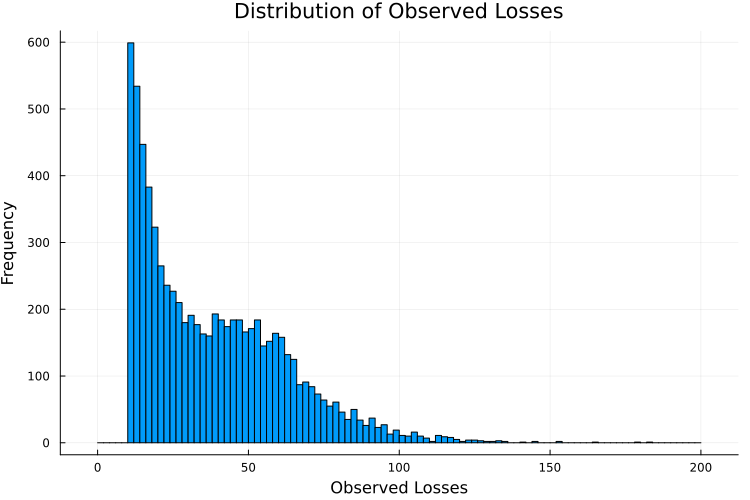

In [22]:
plot_observed_losses(Y_truncated2[:, 2])

We will now fit the left-truncated data with LRMoE, from a starting point reasonably close to the true parameters for illustrative purposes.

In [23]:
α_init = fill(0.0, 2, 5)
experts_init = [LogNormalExpert(3.5, 1.0) InverseGaussianExpert(25.0, 25.0)];

LRMoE_model_truncated2 = fit_LRMoE(Matrix(Y_truncated2), Matrix(X_truncated2), α_init, experts_init;
    exact_Y=false, ϵ=0.01, ecm_iter_max=1000, print_steps=10)

┌ Info: Initial loglik: -32368.771062244763 (no penalty), -32368.771062244763 (with penalty)
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:22
┌ Info: Iteration 10, updating α: -31599.743331854716 ->  -31594.33491405269, ( + 0.01711538522710673 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:76


┌ Info: Iteration 10, updating model[1, 1]: -31594.33491405269 ->  -31534.19116505919, ( + 0.19036244680292497 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


┌ Info: Iteration 10, updating model[1, 2]: -31534.19116505919 ->  -31510.28679759799, ( + 0.07580459995335809 % )
└ @ LRMoE C:\Users\ianwe\.julia\packages\LRMoE\T9K3Q\src\fit\fit_main.jl:111


LRMoESTDFit(LRMoESTD([0.6993180506829522 0.6620615311241755 … 0.06367282110736419 0.8153733409349188; 0.0 0.0 … 0.0 0.0], AnyExpert{LRMoE.NonNegative, LRMoE.NonZI, Distribution{Univariate, Continuous}}[LogNormalExpert{Float64}(3.9924902427645557, 0.3333884576469878) InverseGaussianExpert{Float64}(19.801671524821163, 122.93802437425578)]), true, 15, -31345.662062405314, -31343.764787554803, 62705.529575109606, 62767.66268910594)

We see that the model fit is slightly shifted to account for the data truncation.

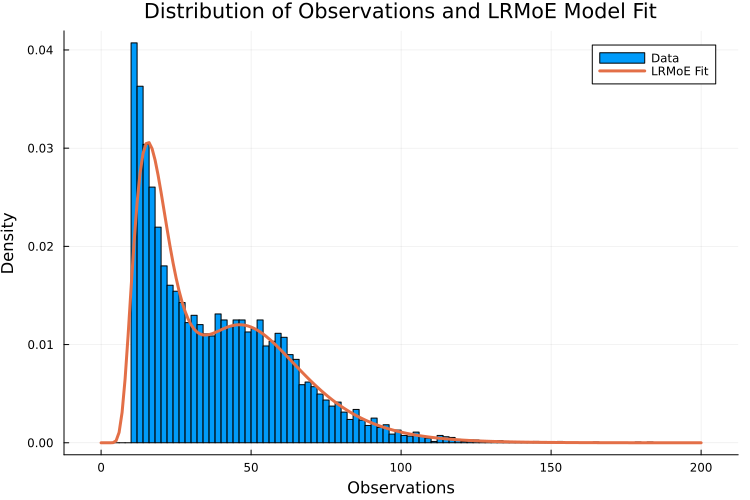

In [24]:
plot_LRMoE_fit(Y_truncated2[:, 2], Matrix(X_truncated2), LRMoE_model_truncated2)

In [25]:
summary(LRMoE_model_truncated2)

Model: LRMoE
Fitting converged after 15 iterations
Dimension of response: 1
Number of components: 2
Loglik: -31345.662062405314
Loglik (no penalty): -31343.764787554803
AIC: 62705.529575109606
BIC: 62767.66268910594
Fitted α:
[0.6993180506829522 0.6620615311241755 -0.03737274360353173 0.06367282110736419 0.8153733409349188; 0.0 0.0 0.0 0.0 0.0]
Fitted component distributions:
AnyExpert{LRMoE.NonNegative, LRMoE.NonZI, Distribution{Univariate, Continuous}}[LogNormalExpert{Float64}(3.9924902427645557, 0.3333884576469878) InverseGaussianExpert{Float64}(19.801671524821163, 122.93802437425578)]


In general, the LRMoE package can handle various combinations of data censoring and truncation, e.g. right-censored data due to policy limits. For more details, please refer to the [documentation](https://actsci.utstat.utoronto.ca/LRMoE.jl/stable/).